In [6]:
# Standard library imports
import os
import xml.etree.ElementTree as ET

# TensorFlow and image processing
import tensorflow as tf
from PIL import Image

# Scikit-learn for model evaluation and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Matplotlib and Seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
# Define paths to your datasets
bccd_annotations_dir = './BCCD_Dataset/BCCD/Annotations'
bccd_images_dir = './BCCD_Dataset/BCCD/Images'
cbc_annotations_dir = './Complete-Blood-Cell-Count-Dataset/Training/Annotations'
cbc_images_dir = './Complete-Blood-Cell-Count-Dataset/Training/Images'

# Function to parse annotation files
def parse_annotations(annotations_dir, images_dir, prefix):
    data = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_dir, filename))
            root = tree.getroot()
            image_filename = filename.replace('.xml', '.jpg')
            image_path = os.path.join(images_dir, image_filename)
            objects = root.findall('object')
            for obj in objects:
                class_name = obj.find('name').text
                bbox = obj.find('bndbox')
                bbox_coords = {
                    'xmin': int(bbox.find('xmin').text),
                    'ymin': int(bbox.find('ymin').text),
                    'xmax': int(bbox.find('xmax').text),
                    'ymax': int(bbox.find('ymax').text)
                }
                data.append({
                    'image_path': image_path,
                    'class': class_name,
                    'bbox': bbox_coords,
                    'prefix': prefix
                })
    return data

# Load BCCD dataset
bccd_data = parse_annotations(bccd_annotations_dir, bccd_images_dir, 'BCCD')

# Load CBC dataset
cbc_data = parse_annotations(cbc_annotations_dir, cbc_images_dir, 'CBC')

# Combine datasets
combined_data = bccd_data + cbc_data

# Print summary of loaded data
print(f'Total BCCD data items: {len(bccd_data)}')
print(f'Total CBC data items: {len(cbc_data)}')
print(f'Total combined data items: {len(combined_data)}')


Total BCCD data items: 4888
Total CBC data items: 3952
Total combined data items: 8840


In [8]:
# Define directories
bccd_image_dir = './BCCD_Dataset/BCCD/JPEGImages'
bccd_annotation_dir = './BCCD_Dataset/BCCD/Annotations'

cbc_image_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Training/Images',
    './Complete-Blood-Cell-Count-Dataset/Validation/Images',
    './Complete-Blood-Cell-Count-Dataset/Testing/Images'
]
cbc_annotation_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Training/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Validation/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Testing/Annotations'
]

pbc_image_dirs = [
    './PBC_dataset_normal_DIB/basophil',
    './PBC_dataset_normal_DIB/eosinophil',
    './PBC_dataset_normal_DIB/erythroblast',
    './PBC_dataset_normal_DIB/ig',
    './PBC_dataset_normal_DIB/lymphocyte',
    './PBC_dataset_normal_DIB/monocyte',
    './PBC_dataset_normal_DIB/neutrophil',
    './PBC_dataset_normal_DIB/platelet'
]

# Verify directories existence
for dir_path in [bccd_image_dir] + cbc_image_dirs + pbc_image_dirs:
    if not os.path.exists(dir_path):
        raise FileNotFoundError(f"Directory not found: {dir_path}")

# Create unified dataset directory
unified_image_dir = './unified_dataset/Images'
os.makedirs(unified_image_dir, exist_ok=True)

def create_symlink_with_prefix(image_dir, prefix):
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            src = os.path.join(image_dir, filename)
            dst = os.path.join(unified_image_dir, f"{prefix}_{filename}")
            try:
                os.symlink(src, dst)
            except FileExistsError:
                print(f"Warning: Skipping duplicate image {dst}")

# Create symbolic links with prefixes to avoid naming conflicts
create_symlink_with_prefix(bccd_image_dir, 'bccd')

for i, dir_path in enumerate(cbc_image_dirs):
    create_symlink_with_prefix(dir_path, f'cbc_{i}')

for i, dir_path in enumerate(pbc_image_dirs):
    create_symlink_with_prefix(dir_path, f'pbc_{i}')

print("Unified dataset created successfully.")

Unified dataset created successfully.


In [9]:
def get_bccd_classes(annotation_dir):
    classes = set()
    for filename in os.listdir(annotation_dir):
        if filename.endswith('.xml'):
            tree = ET.parse(os.path.join(annotation_dir, filename))
            root = tree.getroot()
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                classes.add(class_name)
    return classes

bccd_annotation_dir = './BCCD_Dataset/BCCD/Annotations'
bccd_classes = get_bccd_classes(bccd_annotation_dir)
print(f"BCCD Classes: {bccd_classes}")

cbc_annotation_dirs = [
    './Complete-Blood-Cell-Count-Dataset/Testing/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Training/Annotations',
    './Complete-Blood-Cell-Count-Dataset/Validation/Annotations'
]

cbc_classes = set()
for dir_path in cbc_annotation_dirs:
    cbc_classes.update(get_bccd_classes(dir_path))

print(f"CBC Classes: {cbc_classes}")

pbc_classes = set(os.listdir('./PBC_dataset_normal_DIB'))
print(f"PBC Classes: {pbc_classes}")

# Combine all classes
all_classes = bccd_classes.union(cbc_classes).union(pbc_classes)
print(f"All Classes: {all_classes}")
num_classes = len(all_classes)

# Create a mapping from class names to indices
class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}
print(f"Class to Index Mapping: {class_to_index}")


BCCD Classes: {'Platelets', 'WBC', 'RBC'}
CBC Classes: {'Platelets', 'WBC', 'RBC'}
PBC Classes: {'lymphocyte', 'monocyte', 'New folder', 'eosinophil', 'neutrophil', 'erythroblast', 'basophil', 'platelet', 'ig'}
All Classes: {'lymphocyte', 'Platelets', 'WBC', 'RBC', 'monocyte', 'New folder', 'eosinophil', 'neutrophil', 'erythroblast', 'basophil', 'platelet', 'ig'}
Class to Index Mapping: {'lymphocyte': 0, 'Platelets': 1, 'WBC': 2, 'RBC': 3, 'monocyte': 4, 'New folder': 5, 'eosinophil': 6, 'neutrophil': 7, 'erythroblast': 8, 'basophil': 9, 'platelet': 10, 'ig': 11}


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Directory paths
bccd_dir = './BCCD_Dataset/BCCD/JPEGImages/'
cbcc_dir = './Complete-Blood-Cell-Count-Dataset/Training/Images/'
pbc_dir = './PBC_dataset_normal_DIB/'

# Class names and indices
class_names = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'Lymphocyte', 
               'monocyte', 'neutrophil', 'platelet', 'RBC', 'WBC', 'other']
class_to_index = {name: index for index, name in enumerate(class_names)}

# Function to check if an image file is valid
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image file: {image_path} - {e}")
        return False

# Get all file paths and corresponding labels
def get_all_files_and_labels():
    all_files = []
    for class_name in class_names:
        # PBC dataset
        pbc_class_dir = os.path.join(pbc_dir, class_name)
        if os.path.isdir(pbc_class_dir):
            pbc_files = [os.path.join(pbc_class_dir, f) for f in os.listdir(pbc_class_dir) if f.endswith('.jpg')]
            valid_pbc_files = [(f, class_to_index[class_name]) for f in pbc_files if is_valid_image(f)]
            all_files.extend(valid_pbc_files)

        # BCCD dataset
        bccd_files = [os.path.join(bccd_dir, f) for f in os.listdir(bccd_dir) if f.endswith('.jpg')]
        valid_bccd_files = [(f, class_to_index['RBC'] if 'RBC' in f else class_to_index['WBC'] if 'WBC' in f else class_to_index['platelet']) for f in bccd_files if is_valid_image(f)]
        all_files.extend(valid_bccd_files)

        # CBCC dataset
        cbcc_files = [os.path.join(cbcc_dir, f) for f in os.listdir(cbcc_dir) if f.endswith('.jpg')]
        valid_cbcc_files = [(f, class_to_index['RBC'] if 'RBC' in f else class_to_index['WBC'] if 'WBC' in f else class_to_index['platelet']) for f in cbcc_files if is_valid_image(f)]
        all_files.extend(valid_cbcc_files)

    return all_files

all_files_and_labels = get_all_files_and_labels()

# Create a TensorFlow dataset
file_paths, labels = zip(*all_files_and_labels)
list_ds = tf.data.Dataset.from_tensor_slices((list(file_paths), list(labels)))
print("list_ds:")
print(list_ds)


list_ds:
<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [11]:
# Define the parse function for the datasets
def parse_function(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image, label

# Apply the parse function and batch the datasets
train_ds = list_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

# Ensure there are batches to process
assert tf.data.experimental.cardinality(train_ds).numpy() > 0, "The dataset is empty!"
print("Dataset after batching and prefetching:")
for batch in train_ds.take(1):
    print(batch)


Dataset after batching and prefetching:
(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[250.91797, 227.91797, 195.91797],
         [249.28125, 226.28125, 194.28125],
         [246.38672, 223.38672, 191.38672],
         ...,
         [248.44983, 229.01953, 196.01953],
         [251.68604, 228.80396, 197.80396],
         [234.02344, 208.10547, 180.85938]],

        [[252.     , 229.     , 197.     ],
         [252.82312, 229.82312, 197.82312],
         [250.22266, 227.22266, 195.22266],
         ...,
         [252.53955, 229.80103, 198.80103],
         [241.73438, 215.3103 , 192.38062],
         [217.2926 , 186.20776, 171.30823]],

        [[249.9447 , 226.9447 , 194.9447 ],
         [251.41016, 228.41016, 196.41016],
         [250.19226, 227.19226, 195.19226],
         ...,
         [249.20007, 223.73132, 195.13757],
         [226.81458, 196.41772, 178.70886],
         [211.27795, 176.27795, 171.64514]],

        ...,

        [[251.     , 230.     , 203.     ],
  

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Define data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

# Load and preprocess the dataset (assuming list_ds has been defined as your file paths and labels)
def preprocess_image(file_path, label):
    # Load the image from file
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image as a JPEG file
    image = tf.image.resize(image, [224, 224])  # Resize all images to 224x224 (or any desired size)
    image /= 255.0  # Normalize the pixel values to [0, 1]
    return image, label

# Apply preprocessing to the dataset
train_ds = list_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Apply data augmentation to the training dataset
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

# Batch the dataset (adjust the batch size as needed)
train_ds = train_ds.batch(32)

# Prefetch the dataset for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# Print summary of dataset
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [13]:
# Split the dataset into training and testing sets (80% training, 20% testing)
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets for training and testing
train_ds = tf.data.Dataset.from_tensor_slices((list(train_files), list(train_labels)))
test_ds = tf.data.Dataset.from_tensor_slices((list(test_files), list(test_labels)))

# Apply the parse function and batch the datasets
train_ds = train_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
test_ds = test_ds.map(parse_function, num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

# Ensure there are batches to process
assert tf.data.experimental.cardinality(train_ds).numpy() > 0, "The training dataset is empty!"
assert tf.data.experimental.cardinality(test_ds).numpy() > 0, "The testing dataset is empty!"

print("Training dataset:")
for batch in train_ds.take(1):
    print(batch)

print("Testing dataset:")
for batch in test_ds.take(1):
    print(batch)


Training dataset:
(<tf.Tensor: shape=(32, 128, 128, 3), dtype=float32, numpy=
array([[[[255.     , 230.17175, 199.3706 ],
         [250.40698, 224.40698, 190.5625 ],
         [241.68091, 209.27014, 188.02856],
         ...,
         [201.8125 , 165.40625, 161.875  ],
         [216.85156, 176.69531, 171.28906],
         [241.0155 , 214.203  , 186.828  ]],

        [[241.05151, 214.07458, 186.12573],
         [223.16797, 189.83374, 176.21265],
         [212.92993, 175.17603, 172.00806],
         ...,
         [200.875  , 163.59949, 163.80676],
         [209.86328, 168.88391, 167.10327],
         [233.33594, 205.61719, 182.42114]],

        [[219.68689, 185.22925, 177.17517],
         [210.38306, 171.49841, 173.44739],
         [210.53125, 170.71228, 165.97571],
         ...,
         [198.8164 , 161.41016, 163.8789 ],
         [207.40625, 166.0841 , 166.61304],
         [233.6211 , 205.8086 , 184.4336 ]],

        ...,

        [[253.58984, 232.58984, 205.58984],
         [253.58984, 232

In [14]:
import tensorflow as tf

# Define the model creation function
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),  # Define input shape explicitly using Input layer
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer for classification
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model()

# Print model summary
model.summary()

# Train the model (assuming train_ds is already defined)
history = model.fit(train_ds, epochs=10)

# Evaluate the model on the test dataset (assuming test_ds is defined)
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,832,267 (6.99 MB)

 Trainable params: 1,832,267 (6.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 117s 188ms/step - accuracy: 0.6859 - loss: 2.4728
Epoch 2/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 111s 182ms/step - accuracy: 0.9075 - loss: 0.2692
Epoch 3/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 107s 176ms/step - accuracy: 0.9437 - loss: 0.1732
Epoch 4/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 111s 181ms/step - accuracy: 0.9554 - loss: 0.1293
Epoch 5/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 112s 184ms/step - accuracy: 0.9581 - loss: 0.1219
Epoch 6/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 121s 199ms/step - accuracy: 0.9648 - loss: 0.1025
Epoch 7/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 114s 185ms/step - accuracy: 0.9638 - loss: 0.1012
Epoch 8/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 110s 180ms/step - accuracy: 0.9662 - loss: 0.1020
Epoch 9/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 109s 179ms/step - accuracy: 0.9732 - loss: 0.0830
Epoch 10/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 113s 185ms/step - accuracy: 0.9701 - loss: 0.0867
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.9580 - loss: 0.1330
Test Loss: 0.141975983

In [15]:
# Print the history dictionary
print(history.history)


{'accuracy': [0.8098995685577393, 0.9147878885269165, 0.9434822797775269, 0.9518343806266785, 0.9601865410804749, 0.964798092842102, 0.9658229351043701, 0.9616212248802185, 0.9739188551902771, 0.9725353717803955], 'loss': [0.8162916898727417, 0.24710553884506226, 0.1693466454744339, 0.13410186767578125, 0.11525329947471619, 0.09988173842430115, 0.09759749472141266, 0.11192066222429276, 0.07739924639463425, 0.07796471565961838]}


Cell Detected:
 - Size (Area): 1055.5
 - Aspect Ratio (Width/Height): 1.1694915254237288
 - Circularity: 0.1642763324098972
 - Average Color (BGR): [203.83984279 126.50331614 141.79562761]


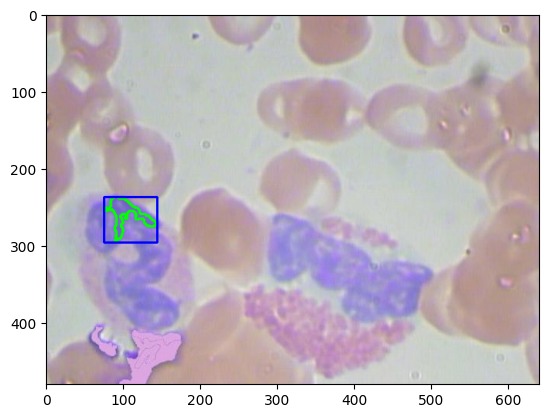

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_features(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply threshold to get binary image
    _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Loop over all detected contours
    for contour in contours:
        # Skip small contours to filter noise
        if cv2.contourArea(contour) < 100:
            continue

        # Get bounding rectangle around the contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Extract the Region of Interest (ROI)
        cell_roi = image[y:y+h, x:x+w]

        # Calculate the size (area) of the cell
        size = cv2.contourArea(contour)
        
        # Calculate the shape features (aspect ratio and circularity)
        aspect_ratio = float(w) / h
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * (cv2.contourArea(contour) / (perimeter ** 2))

        # Calculate the average color in the ROI
        avg_color_per_row = np.mean(cell_roi, axis=0)
        avg_color = np.mean(avg_color_per_row, axis=0)  # [B, G, R] format

        # Display extracted features
        print(f"Cell Detected:")
        print(f" - Size (Area): {size}")
        print(f" - Aspect Ratio (Width/Height): {aspect_ratio}")
        print(f" - Circularity: {circularity}")
        print(f" - Average Color (BGR): {avg_color}")

        # Draw the contour and bounding box on the image for visualization
        cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Show the image with detected cells and contours
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()

# Example usage:
image_path = r"c:\Users\akank\OneDrive\Documents\Desktop\Blood cell classification\Blood-Cell-Classification\BCCD_Dataset\BCCD\JPEGImages\BloodImage_00010.jpg" # Replace with your image path
extract_features(image_path)


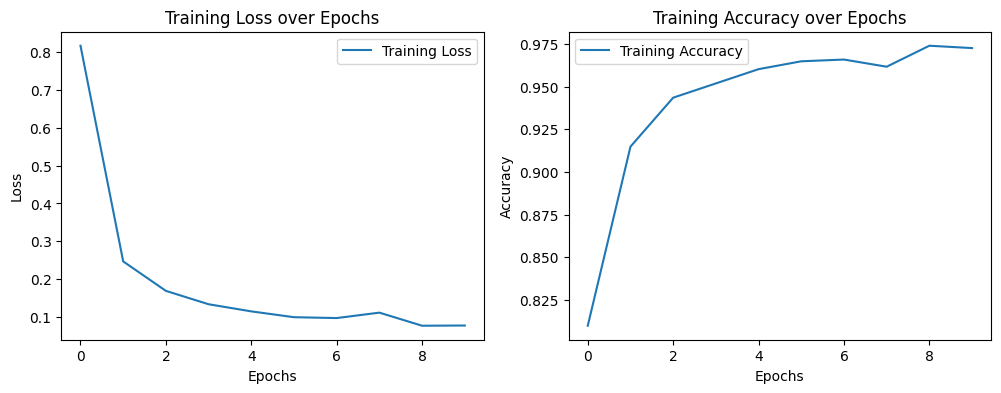

In [17]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history.get('loss', []), label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()



153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step
              precision    recall  f1-score   support

    basophil       0.91      0.96      0.93       238
  eosinophil       1.00      0.98      0.99       663
erythroblast       0.90      0.98      0.94       290
          ig       0.94      0.77      0.85       596
  Lymphocyte       0.96      0.97      0.96       243
    monocyte       0.89      0.91      0.90       280
  neutrophil       0.88      0.98      0.93       665
    platelet       1.00      1.00      1.00      1905

    accuracy                           0.96      4880
   macro avg       0.93      0.94      0.94      4880
weighted avg       0.96      0.96      0.95      4880



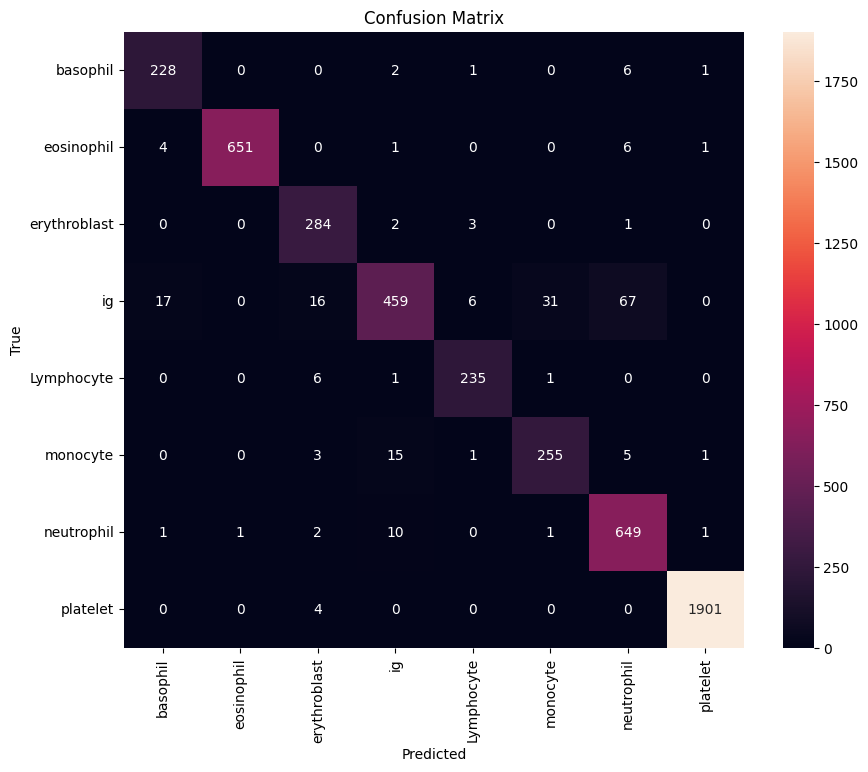

In [18]:
# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Get true labels
y_true = tf.concat([y for x, y in test_ds], axis=0)

# Ensure both y_true and y_pred_classes are in the same format
y_true = y_true.numpy()
y_pred_classes = y_pred_classes.numpy()

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names[:8])  # Assuming only 8 classes are present in test data
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=list(range(8)))  # Labels are indices of the present classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names[:8], yticklabels=class_names[:8])  # Assuming only 8 classes are present
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [21]:
# Save the entire model as a SavedModel.
model.save('model/my_model')


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=model/my_model.

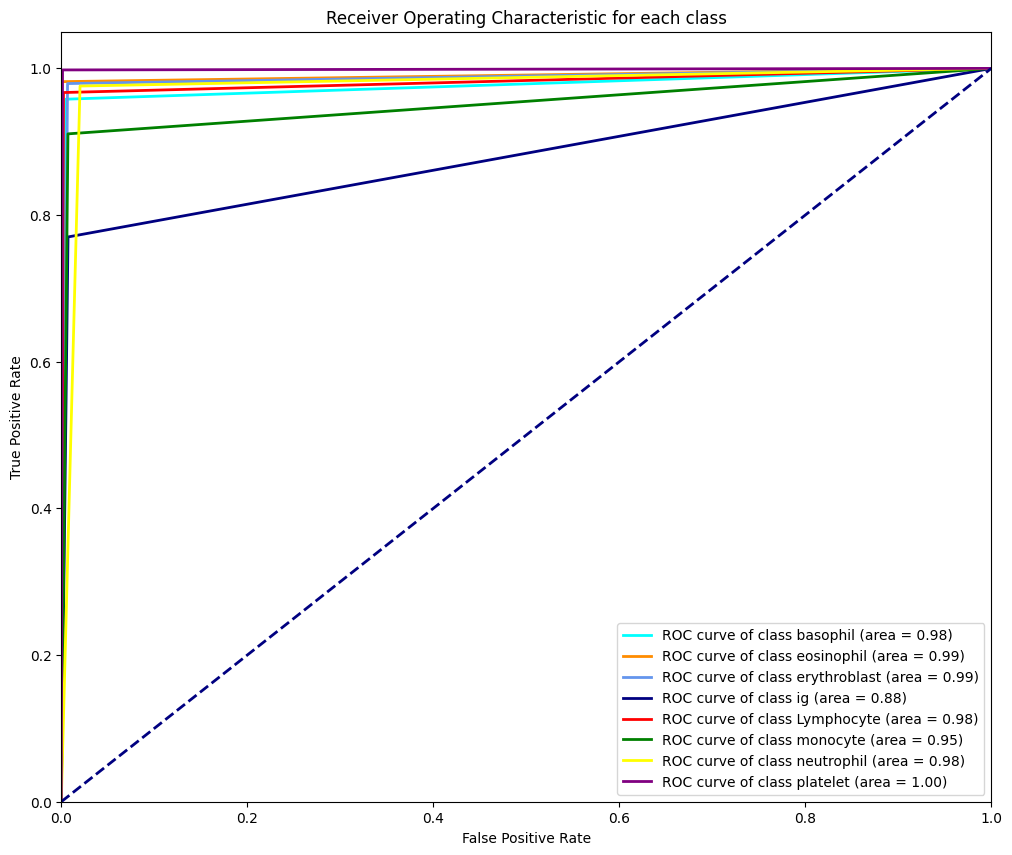

In [25]:
# Assuming y_true and y_pred are your true and predicted labels respectively
n_classes = len(class_names)

# Binarize the output
y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
y_pred_binarized = label_binarize(y_pred_classes, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    if y_true_binarized[:, i].sum() == 0:
        continue  # Skip classes with no positive samples in y_true
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(12, 10))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'grey']
for i in range(n_classes):
    if i in fpr:  # Plot only for classes with valid ROC values
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


In [26]:
from keras.models import load_model

model = load_model(r'C:\Users\akank\OneDrive\Documents\Desktop\Blood cell classification\Blood-Cell-Classification\blood_cell_model.h5')



📋 Summary Table of Extracted Features:

   Cell ID    Area  Aspect Ratio  Circularity    Avg Blue   Avg Green  \
0        1  5185.5      1.147059     0.221843  206.780878  117.613457   
1        2  1679.0      0.947368     0.323765  213.560429  104.333008   
2        3   242.0      0.772727     0.814259  214.451872   96.296791   

      Avg Red  
0  154.958187  
1  148.774204  
2  138.254011  

✅ Features saved to: c:\Users\akank\OneDrive\Documents\Desktop\Blood cell classification\Blood-Cell-Classification\cell_features.csv


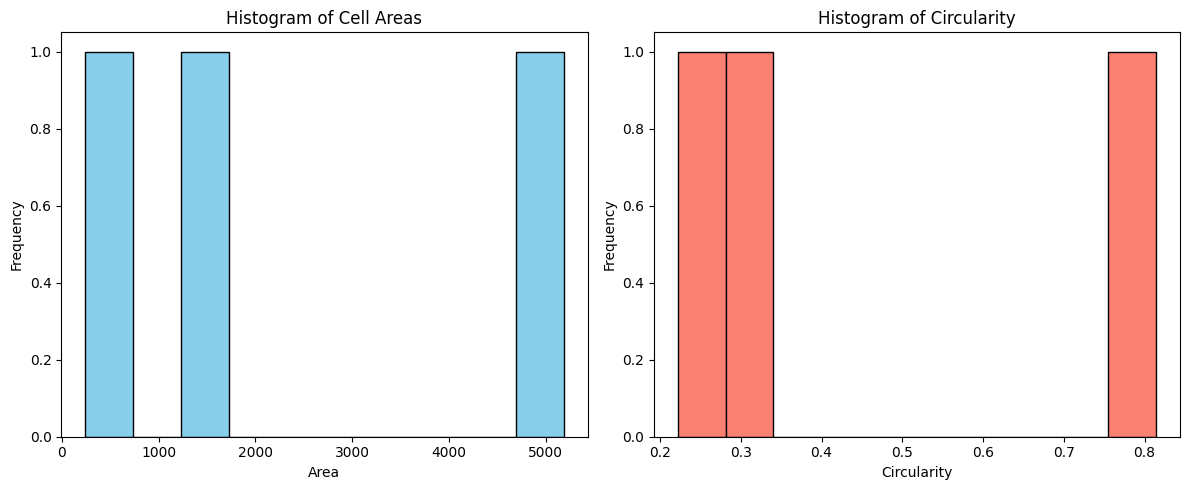

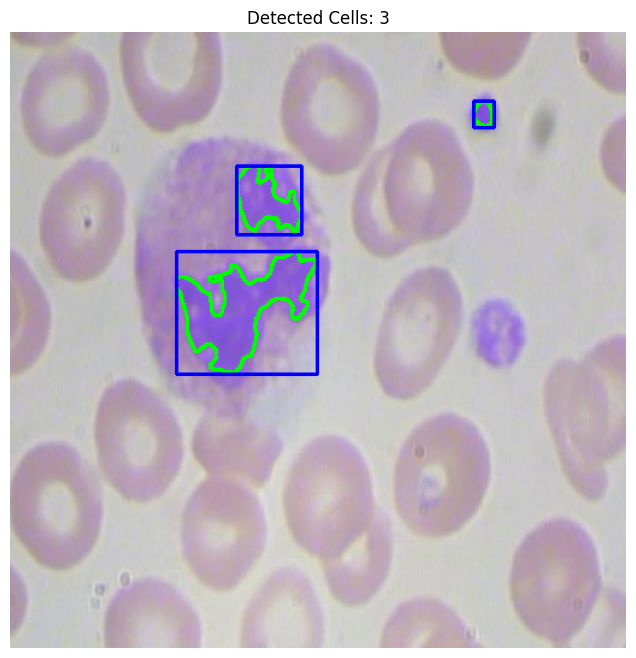

In [1]:
     
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def extract_features_with_summary(image_path, output_csv='cell_features.csv'):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found.")
        return

    # Preprocessing
    resized_image = cv2.resize(image, (512, 512))
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    cell_count = 0

    for contour in contours:
        if cv2.contourArea(contour) < 100:
            continue

        cell_count += 1
        x, y, w, h = cv2.boundingRect(contour)
        cell_roi = resized_image[y:y+h, x:x+w]
        size = cv2.contourArea(contour)
        aspect_ratio = float(w) / h
        perimeter = cv2.arcLength(contour, True)
        circularity = (4 * np.pi * size) / (perimeter ** 2) if perimeter != 0 else 0
        avg_color = np.mean(cell_roi.reshape(-1, 3), axis=0)  # [B, G, R]

        # Save feature dict
        features.append({
            'Cell ID': cell_count,
            'Area': size,
            'Aspect Ratio': aspect_ratio,
            'Circularity': circularity,
            'Avg Blue': avg_color[0],
            'Avg Green': avg_color[1],
            'Avg Red': avg_color[2]
        })

        # Visualization
        cv2.drawContours(resized_image, [contour], -1, (0, 255, 0), 2)
        cv2.rectangle(resized_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Convert to DataFrame
    df = pd.DataFrame(features)
    print("\n📋 Summary Table of Extracted Features:\n")
    print(df)

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Features saved to: {os.path.abspath(output_csv)}")

    # Histogram plots
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(df['Area'], bins=10, color='skyblue', edgecolor='black')
    plt.title('Histogram of Cell Areas')
    plt.xlabel('Area')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(df['Circularity'], bins=10, color='salmon', edgecolor='black')
    plt.title('Histogram of Circularity')
    plt.xlabel('Circularity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Show final annotated image
    plt.figure(figsize=(8, 8))
    plt.title(f'Detected Cells: {cell_count}')
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage
image_path = r"C:\Users\akank\OneDrive\Documents\Desktop\Blood cell classification\Blood-Cell-Classification\BCCD_Dataset\BCCD\JPEGImages\BloodImage_00395.jpg"
extract_features_with_summary(image_path)
